In [30]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.optimize import curve_fit
from shapely.geometry import Polygon, box
import geopandas as gpd
import os, scipy
import warnings
warnings.filterwarnings('ignore')

# load data

In [31]:
infile_info = '/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv'
df_info = pd.read_csv(infile_info)

In [3]:
# Defa + Obs sensitivity
df_defa = []
for i in range(len(df_info)):
    filei = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/LongTermSimu/Defa/level1_{i}/Q_sensitivity_nocalib.csv'
    dfi = pd.read_csv(filei)
    dfi['basin'] = i
    df_defa.append(dfi)

df_defa = pd.concat(df_defa)

In [4]:
# Optmz + Obs sensitivity
ranks = [1, 3, 5, 10, 20]
df_optm = []
for i in range(len(df_info)):
    dfb = []
    for r in ranks:
        filei = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/LongTermSimu/LSEallbasin/level1_{i}/normKGEr{r}/Q_sensitivity_nocalib.csv'
        if os.path.isfile(filei):
            dfi = pd.read_csv(filei)
        else:
            dfi = dfi.copy()
            dfi['Obs']=np.nan
            dfi['Simu']=np.nan
            print('Missing:', filei)
        dfi['basin'] = i
        dfi['param'] = f'normKGEr{r}'
        dfb.append(dfi)

    dfb = pd.concat(dfb)
    df_optm.append(dfb)

df_optm = pd.concat(df_optm)

Missing: /glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/LongTermSimu/LSEallbasin/level1_13/normKGEr3/Q_sensitivity_nocalib.csv
Missing: /glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/LongTermSimu/LSEallbasin/level1_119/normKGEr3/Q_sensitivity_nocalib.csv
Missing: /glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/LongTermSimu/LSEallbasin/level1_142/normKGEr20/Q_sensitivity_nocalib.csv
Missing: /glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/LongTermSimu/LSEallbasin/level1_329/normKGEr1/Q_sensitivity_nocalib.csv
Missing: /glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/LongTermSimu/LSEallbasin/level1_329/normKGEr3/Q_sensitivity_nocalib.csv
Missing: /glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/LongTermSimu/LSEallbasin/level1_329/normKGEr10/Q_sensitivity_nocalib.csv
Missing: /glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/LongTermSimu/LSEallbasin/level1_329/normKGEr20/Q_sensitivity_nocalib.csv
Missing: /glade/campaign/cgd/tss

# test diff

Variable T
ranks [1, 3, 5, 10, 20]
mean [-1.04935099 -1.24444118 -1.38283156 -1.48498102 -1.16401085]
median [0.20702657 0.28870332 0.22791923 0.19847203 0.32437505]
std [10.71045847 11.15893999 12.22779801 11.95459194 12.06194025]
Variable P
ranks [1, 3, 5, 10, 20]
mean [1.77648612 1.74321862 1.74626144 1.73948588 1.74415006]
median [1.65419882 1.63969703 1.6259267  1.61388228 1.63150022]
std [0.73133294 0.76071199 0.71517504 0.71478008 0.7140255 ]
Variable PT
ranks [1, 3, 5, 10, 20]
mean [-0.25196302 -0.24451394 -0.2516286  -0.25156784 -0.2455282 ]
median [-0.07764113 -0.08158578 -0.08203373 -0.08300637 -0.07787866]
std [0.55622873 0.55602053 0.57077267 0.55395546 0.56741848]


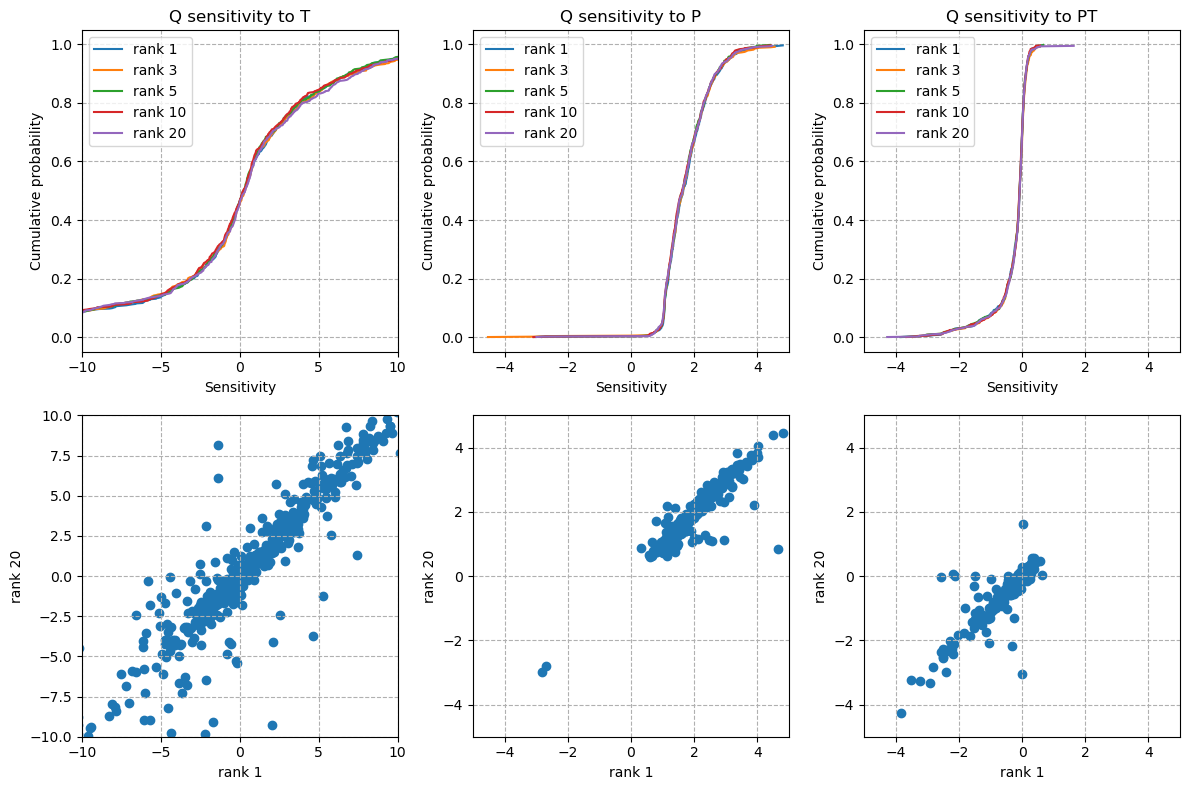

In [5]:

fig = plt.figure(figsize=[12, 8])

flag = 1
for v in ['T', 'P', 'PT']:
    fig.add_subplot(2,3,flag)

    s1 = []
    for r in ranks:
        dr = df_optm[ (df_optm['param']==f'normKGEr{r}') & (df_optm['senst']==v) ]['Simu'].values
        s1.append(dr)
    s1 = np.array(s1).T

    print('Variable', v)
    print('ranks', ranks)
    print('mean', np.nanmean(s1,axis=0))
    print('median', np.nanmedian(s1,axis=0))
    print('std', np.nanstd(s1,axis=0))


    for i in range(5):
        plt.plot(np.sort(s1[:,i]), np.arange(s1.shape[0])/s1.shape[0], label=f'rank {ranks[i]}')

    if v == 'T':
        plt.xlim(-10, 10)
    else:
        plt.xlim(-5, 5)
    plt.legend()
    plt.title('Q sensitivity to '+v)
    plt.grid('on', linestyle='--')
    plt.xlabel('Sensitivity')
    plt.ylabel('Cumulative probability')



    fig.add_subplot(2,3,flag+3)

    plt.scatter(s1[:,0], s1[:,-1])
    plt.xlabel(f'rank {ranks[0]}')
    plt.ylabel(f'rank {ranks[-1]}')
    plt.grid('on', linestyle='--')

    if v == 'T':
        plt.xlim(-10, 10)
        plt.ylim(-10, 10)
    else:
        plt.xlim(-5, 5)
        plt.ylim(-5, 5)
    
    flag = flag+1

plt.tight_layout()
plt.show()

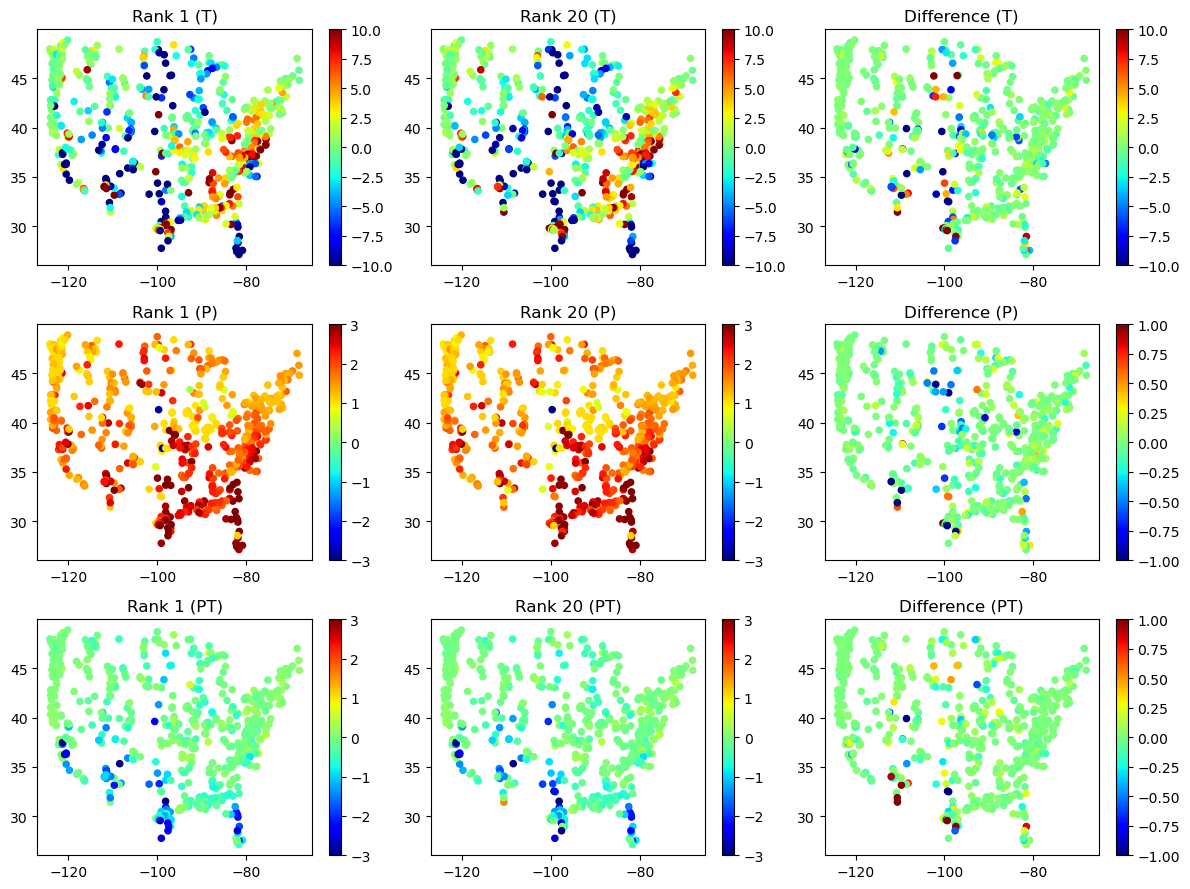

In [34]:
# Assuming df_optm and df_info are already defined and contain the necessary data
lat = df_info['lat_cen'].values
lon = df_info['lon_cen'].values

fig, axes = plt.subplots(3, 3, figsize=[12, 9])

# Plotting for 'T'
r = 1
v = 'T'
d1 = df_optm[(df_optm['param'] == f'normKGEr{r}') & (df_optm['senst'] == v)]['Simu'].values
r = 20
d2 = df_optm[(df_optm['param'] == f'normKGEr{r}') & (df_optm['senst'] == v)]['Simu'].values

sc = axes[0, 0].scatter(lon, lat, 20, d1, vmin=-10, vmax=10, cmap='jet')
axes[0, 0].set_title('Rank 1 (T)')
fig.colorbar(sc, ax=axes[0, 0])

sc = axes[0, 1].scatter(lon, lat, 20, d2, vmin=-10, vmax=10, cmap='jet')
axes[0, 1].set_title('Rank 20 (T)')
fig.colorbar(sc, ax=axes[0, 1])

sc = axes[0, 2].scatter(lon, lat, 20, d2 - d1, vmin=-10, vmax=10, cmap='jet')
axes[0, 2].set_title('Difference (T)')
fig.colorbar(sc, ax=axes[0, 2])

# Plotting for 'P'
r = 1
v = 'P'
d1 = df_optm[(df_optm['param'] == f'normKGEr{r}') & (df_optm['senst'] == v)]['Simu'].values
r = 20
d2 = df_optm[(df_optm['param'] == f'normKGEr{r}') & (df_optm['senst'] == v)]['Simu'].values

sc = axes[1, 0].scatter(lon, lat, 20, d1, vmin=-3, vmax=3, cmap='jet')
axes[1, 0].set_title('Rank 1 (P)')
fig.colorbar(sc, ax=axes[1, 0])

sc = axes[1, 1].scatter(lon, lat, 20, d2, vmin=-3, vmax=3, cmap='jet')
axes[1, 1].set_title('Rank 20 (P)')
fig.colorbar(sc, ax=axes[1, 1])

sc = axes[1, 2].scatter(lon, lat, 20, d2 - d1, vmin=-1, vmax=1, cmap='jet')
axes[1, 2].set_title('Difference (P)')
fig.colorbar(sc, ax=axes[1, 2])

# Plotting for 'PT'
r = 1
v = 'PT'
d1 = df_optm[(df_optm['param'] == f'normKGEr{r}') & (df_optm['senst'] == v)]['Simu'].values
r = 20
d2 = df_optm[(df_optm['param'] == f'normKGEr{r}') & (df_optm['senst'] == v)]['Simu'].values

sc = axes[2, 0].scatter(lon, lat, 20, d1, vmin=-3, vmax=3, cmap='jet')
axes[2, 0].set_title('Rank 1 (PT)')
fig.colorbar(sc, ax=axes[2, 0])

sc = axes[2, 1].scatter(lon, lat, 20, d2, vmin=-3, vmax=3, cmap='jet')
axes[2, 1].set_title('Rank 20 (PT)')
fig.colorbar(sc, ax=axes[2, 1])

sc = axes[2, 2].scatter(lon, lat, 20, d2 - d1, vmin=-1, vmax=1, cmap='jet')
axes[2, 2].set_title('Difference (PT)')
fig.colorbar(sc, ax=axes[2, 2])

plt.tight_layout()
plt.show()
